# Garments Classification Model

## Import Requirements

In [127]:
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import *
from fastai.imports import *
import gc
import pandas as pd

%matplotlib inline

## Import dataset

In [128]:
list_cloth_path = "../Dataset/DeepFashion_DS/DeepFashion_DS_TextFiles/list_category_cloth.txt"
list_img_path = "../Dataset/DeepFashion_DS/DeepFashion_DS_TextFiles/list_category_img.txt"

df_cloth=pd.read_csv(list_cloth_path,skiprows=1,delim_whitespace=True)
df_img=pd.read_csv(list_img_path,skiprows=1,delim_whitespace=True)

In [129]:
df_cloth.to_dict()
category_map = df_cloth
category_map["value"] = category_map.index + 1

In [130]:
dict_category = category_map.set_index("value").to_dict()["category_name"]
dict_cloth = category_map.set_index("category_name").to_dict()["category_type"]

In [131]:
df = df_img
df["category_label"] = df["category_label"].map(dict_category)
df["garment_type"] = df["category_label"].map(dict_cloth)

In [132]:
df["image_name"] = df["image_name"].str.replace("img/","DeepFashion_DS/DeepFashion_DS_IMG/")

In [133]:
df

,image_name,category_label,garment_type
0,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000001.jpg,Blouse,1
1,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000002.jpg,Blouse,1
2,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000003.jpg,Blouse,1
3,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000004.jpg,Blouse,1
4,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000005.jpg,Blouse,1
...,...,...,...
289217,DeepFashion_DS/DeepFashion_DS_IMG/Paisley_Print_Babydoll_Dress/img_00000050.jpg,Dress,3
289218,DeepFashion_DS/DeepFashion_DS_IMG/Paisley_Print_Babydoll_Dress/img_00000051.jpg,Dress,3
289219,DeepFashion_DS/DeepFashion_DS_IMG/Paisley_Print_Babydoll_Dress/img_00000052.jpg,Dress,3
289220,DeepFashion_DS/DeepFashion_DS_IMG/Paisley_Print_Babydoll_Dress/img_00000053.jpg,Dress,3


In [134]:
shoe_df = pd.DataFrame(columns = ['image_name', 'category_label'])

root = "../Dataset/EdgeNet_Shoe_DS/training/"
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]

for category_name in dirlist:
    route = root + category_name + "/"
    
    directory = os.fsencode(route)

    for file in os.listdir(directory): #for cycle to iterate over folder
        filename = os.fsdecode(file) #get file name
        if filename.endswith(".jpg"): #if ends with .jpg
            shoe_df = shoe_df.append({'image_name' : str("EdgeNet_Shoe_DS/training/"+category_name+"/"+filename), 'category_label' : category_name},ignore_index = True)

/tmp/ipykernel_5044/2656793720.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shoe_df = shoe_df.append({'image_name' : str("EdgeNet_Shoe_DS/training/"+category_name+"/"+filename), 'category_label' : category_name},ignore_index = True)
/tmp/ipykernel_5044/2656793720.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shoe_df = shoe_df.append({'image_name' : str("EdgeNet_Shoe_DS/training/"+category_name+"/"+filename), 'category_label' : category_name},ignore_index = True)
/tmp/ipykernel_5044/2656793720.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shoe_df = shoe_df.append({'image_name' : str("EdgeNet_Shoe_DS/training/"+category_name+"/"+filename), 'category_label' : category_name},ignore_index = True)
/tmp/ipyke

In [135]:
with open('../Dataset/DeepFashion_DS/DeepFashion_DS_TextFiles/train.txt') as f:
    train_list = f.read().splitlines()

train_list = [row.replace("img/","DeepFashion_DS/DeepFashion_DS_IMG/") for row in train_list]

cloth_df = df[df["image_name"].isin(train_list)].drop("garment_type",axis=1)

frames = [cloth_df,shoe_df]

complete_df = pd.concat(frames)

complete_df.to_csv("../Dataset/train_list.csv",index=False)

## Image Load

In [136]:
PATH = "../Dataset/"
TRAINING_PATH = "train_list.csv"

data = ImageDataLoaders.from_csv(PATH, csv_fname=TRAINING_PATH,
                                 item_tfms=Resize(300),
                                 batch_tfms=aug_transforms(size=224, min_scale=0.9),
                                 valid_pct=0.1,
                                 splitter=RandomSplitter(seed=42), #seed=42
                                 num_workers=0)

In [137]:
gc.collect()
torch.cuda.empty_cache()

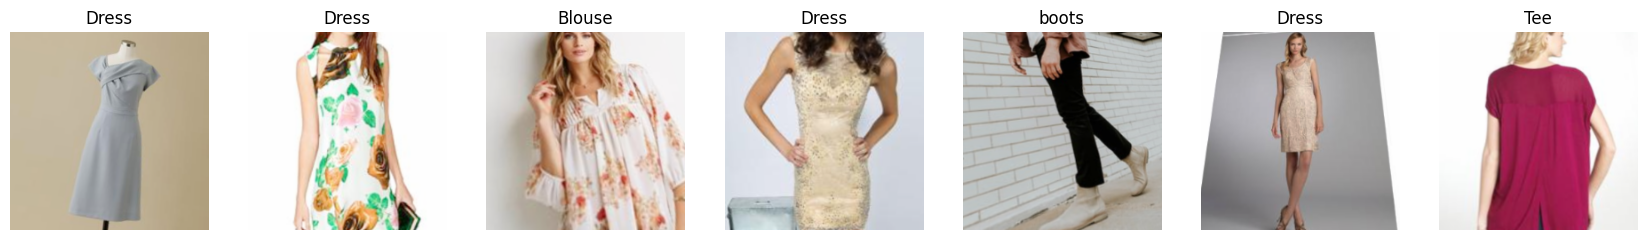

In [138]:
data.show_batch(max_n=7, nrows=1)

## Model Training

In [139]:
learn = cnn_learner(data, resnet34, metrics=[accuracy,error_rate], pretrained=True)
learn.fine_tune(3)
learn.save('stage-1_resnet34')

/home/eltrujo/Repo/FastFit_AI-1/FastFit_AI_env/lib/python3.8/site-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/eltrujo/Repo/FastFit_AI-1/FastFit_AI_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/eltrujo/Repo/FastFit_AI-1/FastFit_AI_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.972391,2.098907,0.487569,0.512431,02:11


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.049778,1.634581,0.565608,0.434392,02:47
1,1.625198,1.444927,0.595304,0.404696,02:44
2,1.346183,1.417599,0.604972,0.395028,02:50


Path('../Dataset/models/stage-1_resnet34.pth')

In [140]:
gc.collect()
torch.cuda.empty_cache()

### Learning rate finder

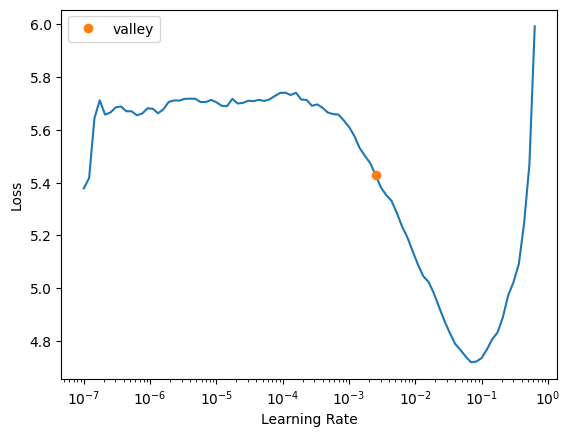

In [141]:
learn = cnn_learner(data, resnet34, metrics=accuracy)
lr_steep = learn.lr_find()

In [142]:
lr_steep

SuggestedLRs(valley=0.002511886414140463)

In [143]:
gc.collect()
torch.cuda.empty_cache()

In [144]:
learn.fine_tune(8, base_lr=5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.631886,1.912244,0.495166,02:08


epoch,train_loss,valid_loss,accuracy,time
0,1.787380,1.644851,0.563536,02:42
1,1.670802,1.593574,0.570442,02:44
2,1.558000,1.559307,0.545580,03:05
3,1.403379,1.442038,0.606354,02:45
4,1.238595,1.411888,0.600138,02:52
5,1.040133,1.385449,0.626381,02:50
6,0.808179,1.427094,0.639503,02:43
7,0.651768,1.419881,0.636740,02:41


### Discriminative Learning Rates

In [145]:
gc.collect()
torch.cuda.empty_cache()

In [146]:
learn.unfreeze()

SuggestedLRs(valley=3.0199516913853586e-05)

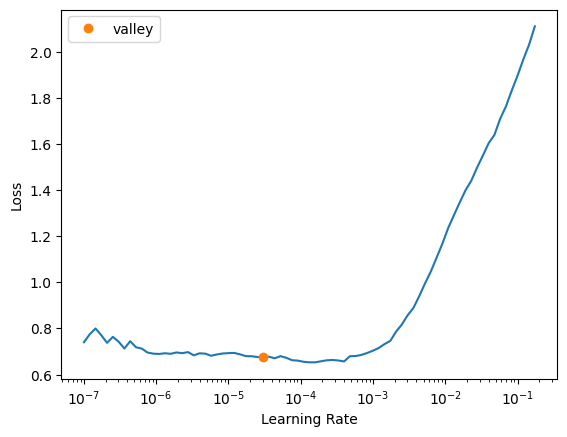

In [147]:
learn.lr_find()

In [148]:
learn.fit_one_cycle(6, lr_max=slice(1e-7, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.641545,1.463477,0.634669,02:39
1,0.620475,1.562783,0.633287,02:39
2,0.620641,1.569568,0.625691,02:40
3,0.581820,1.612767,0.631215,02:41
4,0.547216,1.633407,0.630525,02:42
5,0.528772,1.624537,0.633978,02:43


SuggestedLRs(valley=2.511886486900039e-05)

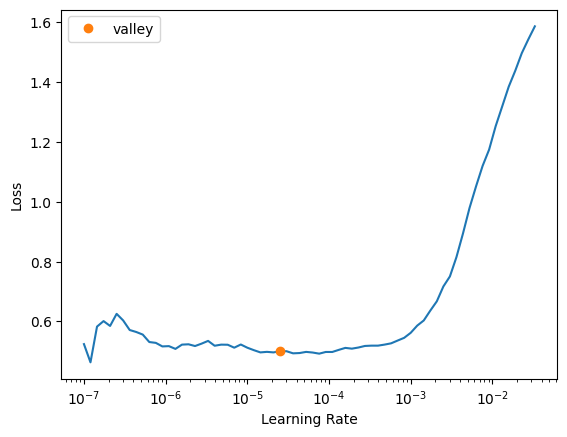

In [149]:
learn.lr_find()

In [151]:
learn.fit_one_cycle(3, lr_max=slice(1e-7, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.568534,1.698336,0.629144,02:44
1,0.556244,1.654344,0.631906,02:45
2,0.505040,1.677963,0.633978,02:45


### Export model

In [154]:
modelname = learn.model
modelname.cpu()
torch.save(modelname, '../Model/stage-1_resnet34.pkl')

## Evaluation

### Mappings

In [174]:
category_dict = {
    "top":      1,
    "bottom":   2, 
    "shoes":    3,
    "onepiece": 4   # ignored in the MVP version
}

formality_dict = {
    "formality":3,
    "casual":2, 
    "sport":1
}

weather_dict = {
    "cold":3,
    "sunny":2, 
    "rainny":1
}

type_dict = {    # category, formality, weather
"Anorak" :        (1, 1, 3),
"Blazer":         (1, 3, 2),
"Blouse":         (1, 2, 2),
"Bomber" :        (1, 2, 3),
"Button-Down":    (1, 2, 2 ),
"Cardigan" :      (1, 2, 3),
"Flannel" :       (1, 2, 3),
"Halter":         (1,2,2),
"Henley" :        (1, 2,3),
"Hoodie" :        (1, 2, 3),
"Jacket" :        (1, 2, 3),
"Jersey"  :       (1, 1, 2),
"Parka"   :       (1,2,3),
"Peacoat" :       (1,3,3),
"Poncho" :        (1,2,3),
"Sweater"  :      (1,2,3),
"Tank" :          (1,3,2),
"Tee" :           (1,2,2),
"Top"  :          (1,2,2),
"Turtleneck" :    (1,3,3),
"Capris" :        (2,2,2),
"Chinos"  :       (2,2,2),
"Culottes"  :     (2,2,2),
"Cutoffs" :       (2,2,2),
"Gauchos"  :      (2,2,2),
"Jeans" :         (2,2,2),
"Jeggings" :      (2,2,2),
"Jodhpurs"  :     (2,1,2),
"Joggers"  :      (2,1,3),
"Leggings"  :     (2,1,2),
"Sarong"  :       (2,2,2),
"Shorts"  :       (2,2,2),
"Skirt"   :       (2, 2,2),
"Sweatpants" :    (2, 1, 3),
"Sweatshorts" :   (2, 1, 2 ),
"Trunks"       :  (2, 1, 2),
"Caftan"       :  (4,3,2),
"Cape"         :  (4,3,3),
"Coat"         :  (4, 3, 3),
"Coverup"      :  (4, 2, 2),
"Dress"        :  (4, 2, 2),
"Jumpsuit"     :  (4, 2, 2),
"Kaftan"        : (4, 3, 2),
"Kimono"         :(4, 3, 2),
"Nightdress"     :(4, 2, 2),
"Onesie"         :(4, 2, 2),
"Robe"           :(4, 2, 2),
"Romper"       :  (4, 2, 2),
"Shirtdress"    : (4, 2, 2),
"Sundress"     :  (4, 2, 2),
"boots":(3, 2, 3) ,
"flip_flops":(3, 2, 3),
"loafers":(3, 3, 2),
"sandals":(3, 2, 2),
"sneakers":(3, 2, 2),
"soccer_shoes":(3,1,2)}

In [189]:
inv_category_dict = dict(zip(category_dict.values(), category_dict.keys()))
inv_formality_dict = dict(zip(formality_dict.values(), formality_dict.keys()))
inv_weather_dict = dict(zip(weather_dict.values(), weather_dict.keys()))

In [194]:
type_df = pd.DataFrame(type_dict).T
type_df.columns = ['Garment_type', 'Formality', 'Weather']

In [195]:
type_df["Garment_type"]=type_df["Garment_type"].map(inv_category_dict)
type_df["Formality"]=type_df["Formality"].map(inv_formality_dict)
type_df["Weather"]=type_df["Weather"].map(inv_weather_dict)

### Predict

In [218]:
pred_df = pd.DataFrame(columns=["image_name","category_label","pred_category_label","garment_type","formality","weather"])

In [220]:
pred_df["image_name"] = complete_df["image_name"]
pred_df["category_label"] = complete_df["category_label"]

In [223]:
pred_df

,image_name,category_label,pred_category_label,garment_type,formality,weather
11,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000012.jpg,Blouse,5,NaN,NaN,NaN
19,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000020.jpg,Blouse,5,NaN,NaN,NaN
71,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000072.jpg,Blouse,5,NaN,NaN,NaN
121,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000122.jpg,Blouse,5,NaN,NaN,NaN
123,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000124.jpg,Blouse,5,NaN,NaN,NaN
...,...,...,...,...,...,...
476,EdgeNet_Shoe_DS/training/sneakers/image189.jpg,sneakers,5,NaN,NaN,NaN
477,EdgeNet_Shoe_DS/training/sneakers/image24.jpg,sneakers,5,NaN,NaN,NaN
478,EdgeNet_Shoe_DS/training/sneakers/image18.jpg,sneakers,5,NaN,NaN,NaN
479,EdgeNet_Shoe_DS/training/sneakers/image242.jpg,sneakers,5,NaN,NaN,NaN


In [222]:
for image in pred_df["image_name"]:
    image_path = "../Dataset/"+image
    pred_df.loc[pred_df["image_name"]==image,"pred_category_label"]=learn.predict(image_path)[0]
    